# Modeling language with Bigrams

The idea is to understand and experiment with the basics of deep neural networs and language modeling using the paper "[A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)" as a base to work off of while using the [Wikitext 2 Raw](https://wikitext.smerity.com/wikitext-2-raw-v1.zip) dataset. Core concepts I wish to explore here:
- Mathematic formalization of the problem of language modeling to arrive at an optimization problem.
- The effects of initialization model parameters and training
- The training loop itself, overfitting and some techniques to prevent it


## Mathematical Foundation

We have a text corpus $T$ of length $n$ characters, from this corpus we derive a dataset $X$ composed of all contiguous bigrams $[x_{i}, x_{i+1}]$ where $i \in 1,\dots,n-1$ (therefore $|X| = n-1$) and $x_{i} \in V$, where $V$ is the set of all characters in $T$ and we say that $|V|=m$. For any character $x_{i}$ the corpus $T$ encodes an underlying, true probability distribution for $x_{i+1}$ :
$$
P(x_{i+1}|x_{i})
$$
Our objective is to approximate that distribution as best we can by using a model composed of parameters $\Theta$ learned from our dataset $X$. The model will use character $x_{i}$ to predict $x_{i+1}$ ideally we would get:
$$
P(x_{i+1}|x_{i}) \approx P(x_{i+1}|x_{i}, \Theta)\in \mathbb{R}^{m}
$$
More practically, we can say that our model is actually a function $f_{\Theta}$ (parameterized by $\Theta$) where:
$$
\text{softmax}(f_{\Theta}(x_{i})) = P(x_{i+1}|x_{i},\Theta)
$$
Where softmax is used to turn our final $m$ logits into a valid probability distribution.

Now, this is an optimization problem. To be precise, we want to minimize the difference between the real distribution and the distribution we're estimating with out model $f_{\Theta}$. For this, we can pull from the idea of cross-entropy which is the measure that we need:
$$
H(p,q)=-\sum p(x)\log q(x)
$$
Applying it to our problem we would get a specific number for the cross-entropy between the relevant distribution this will be our loss and it will be what we want to minimize:
$$
\mathcal{L} = - \sum_{i=1}^{n-1} P(x_{i+1}|x_{i})\log P(x_{i+1}|x_{i},\Theta)
$$
Obviously, we don't have $P(x_{i+1}|x_{i})$, if we did then problem solved we could just use that, instead all we have is our dataset $X$ which tells us a lot about the real distribution for any one *specific* example.

We have all possible bigrams, therefore for any character $x_{i}$ we know what $x_{i+1}$ actually is, therefore we can greatly simplify the problem that assuming that the real distribution $P(x|x_{i})$ has a spike of probability $1$ when $x=x_{i+1}$ and a total of $0$ probability mass when $x=c$, $c$ being any character other than $x_{i+1}$. In formal terms:
$$
P(x|x_{i}) = \begin{cases}
1  &  \text{if} &  x=x_{i+1} \\
0 & \text{otherwise}
\end{cases}
$$
Since we're conditioning our model probability distribution on predicting $x_{i+1}$ we can say that $P(x_{i+1}|x_{i})=1$ and therefore the loss we have to minimize is:
$$
\mathcal{L} = - \sum_{i=1}^{n-1} \log P(x_{i+1}|x_{i},\Theta)
$$
In practice and mostly for computational reasons we instead calculate the loss over mini batches $B$ where $B \subset X$ (a random selection of training examples), therefore the loss we will actually use is:
$$
\mathcal{L} = -\frac{1}{|B|} \sum_{i \in B} \log (\text{softmax} (f_{\Theta}(x_{i}) )_{y_{i}})
$$
Minimizing this loss amounts to maximizing the probability of seeing the index $y_{i}$ (correct next character according to our data) when out model takes in the character $x_{i}$

### Extracting the data from the corpus

The methodology we'll use here is simple. We'll split our dataset by lines and at the ned of every line we'll add an `<EOS>` (end of sentence) special token. This is for two reasons

1. The `<EOS>` token will grant us a natural, trained for stopping point for model generations. If we didn't have it we would have to stop the generation manually.

2. It helps the model learn natural line breaks and document structure. In WikiText, line breaks often represent meaningful boundaries between paragraphs, section headings, or list items. By explicitly marking these with <EOS>, we're teaching the model to recognize and reproduce these structural elements in its generated text, leading to more naturally formatted output that maintains proper paragraph breaks and document hierarchy.

In [1]:
def read_file(path):
    with open(path, 'r', encoding='utf-8') as f:
        return f.read()

train_raw = "./wikitext-2-raw/wiki.train.txt"
val_raw = "./wikitext-2-raw/wiki.val.txt"
test_raw = "./wikitext-2-raw/wiki.test.txt"
train_text = read_file(train_raw)

text_with_eos = train_text + '<EOS>'
chars = sorted(list(set(train_text)))
chars.append('<EOS>')  
vocab_size = len(chars)

# Create our character mappings
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}

# Create bigrams treating <EOS> as a single token
bigrams = []
for i in range(len(train_text)):
    input_char = train_text[i]
    # If we're at the last character, the target is <EOS>
    if i == len(train_text) - 1:
        target_char = '<EOS>'
    else:
        target_char = train_text[i + 1]
    bigrams.append([char_to_idx[input_char], char_to_idx[target_char]])

# Let's look at what we've created
print(f"Vocabulary size: {vocab_size}")
print(f"\nFirst few characters in vocabulary:")
print(chars[:10])
print(f"\nFirst 5 bigrams as character pairs:")
for i in range(5):
    in_idx, out_idx = bigrams[i]
    print(f"'{idx_to_char[in_idx]}' -> '{idx_to_char[out_idx]}'")

print(f"\nLast 5 bigrams as character pairs:")
for i in range(-5, 0):
    in_idx, out_idx = bigrams[i]
    print(f"'{idx_to_char[in_idx]}' -> '{idx_to_char[out_idx]}'")
print(f"\nTotal number of bigrams: {len(bigrams)}")

# Distribution of characters
from collections import Counter
char_counts = Counter(train_text)
print("\nMost common characters:")
for char, count in char_counts.most_common(10):
    if char.isspace():
        char_display = '<space>'
    elif char == '\n':
        char_display = '<newline>'
    else:
        char_display = char
    print(f"'{char_display}': {count}")

Vocabulary size: 1014

First few characters in vocabulary:
['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(']

First 5 bigrams as character pairs:
' ' -> '
'
'
' -> ' '
' ' -> '='
'=' -> ' '
' ' -> 'V'

Last 5 bigrams as character pairs:
'.' -> ' '
' ' -> '
'
'
' -> ' '
' ' -> '
'
'
' -> '<EOS>'

Total number of bigrams: 10918892

Most common characters:
'<space>': 2088677
'e': 990626
't': 690297
'a': 685507
'n': 593094
'i': 588695
'o': 585162
'r': 533179
's': 514154
'h': 387532


In [2]:
import torch

# Creating the dataset
data = torch.tensor(bigrams)

X, Y = data[:, 0], data[:, 1]

X.shape, Y.shape

(torch.Size([10918892]), torch.Size([10918892]))

## On parameter initializations

### The core problem

It's all about the vanishing/exploding gradients problem. If the network parameters are not initialized correctly we *will* crash head first into increasing/vanishing variance (and therefore gradients) as we stack more and more layers. This applies both the forwards and backwards pass.

In a feed-forward network layers compute:
$$
\mathbf{z}^{(\ell)} = W^{(\ell)}\mathbf{a}^{(\ell-1)} +b^{(\ell)}, \quad \mathbf{a}^{(\ell)}=\phi(\mathbf{z}^{(\ell)})
$$
Where $\phi$ is our non linearity (ReLU, Sigmoid) and $\mathbf{a}^{(\ell-1)}$ are the previous layer's activations. If we treat $W^{(\ell)}$ and $\mathbf{a}^{(\ell-1)}$ as linearly independent random variables with 0 mean (which is how they are initialized), then:
$$
\text{Var}(z_{i}^{(\ell)})=\sum_{j=1}^{n_{\ell-1}}\text{Var}(W_{ij}^{(\ell)}a_{j}^{(\ell-1)}) = n_{\ell-1} \text{Var}(W^{(\ell)})\text{Var}(a^{(\ell-1)})
$$
Which means that the variance of this new layer's pre-activations is going to be scaled according to the number of neurons in the previous layers, $n_{(\ell-1)}$ which is not good in either direction. Either the variance explodes and training becomes unstable due to exploding gradients ($\text{Var}(W) \gg \frac{1}{n}$) or it vanishes towards zero and the network ends up learning nothing as the error signals follow suit ($\text{Var}(W)\ll \frac{1}{n}$).  

To address this, and knowing we can control how we initialize our parameters $W$, we must aim for $\text{Var}(W^{(\ell)})$ to be as close as it can be to $\frac{1}{n_{(\ell-1)}}$ as to maintain $\text{Var}(z^{(\ell)})$ stable through training.  



### Validating the theory on a 100 layer MLP

We will do a single backward pass on three 100 layer MLPs, the difference will be in their parameter initialization: 

- One initialized with $\mathcal{N}(0,1)$
- One initialized with $\mathcal{U}(-1,1)$
- One Initialized with $\mathcal{U}(-\sqrt{ k }, \sqrt{ k }), \quad k= \frac{6}{n_{\text{in}}+n_{\text{out}}}$, Xavier/Glorot as we'll be using `tanh`

The model will simply be an embedding layer followed by 100 fully connected layers and then an output layer to bring back the dimension to `vocab_size`, all of dimension $n=64$. The objective is to see how the gradient norm behaves as the error propagates backwards and what that implies for training stability.

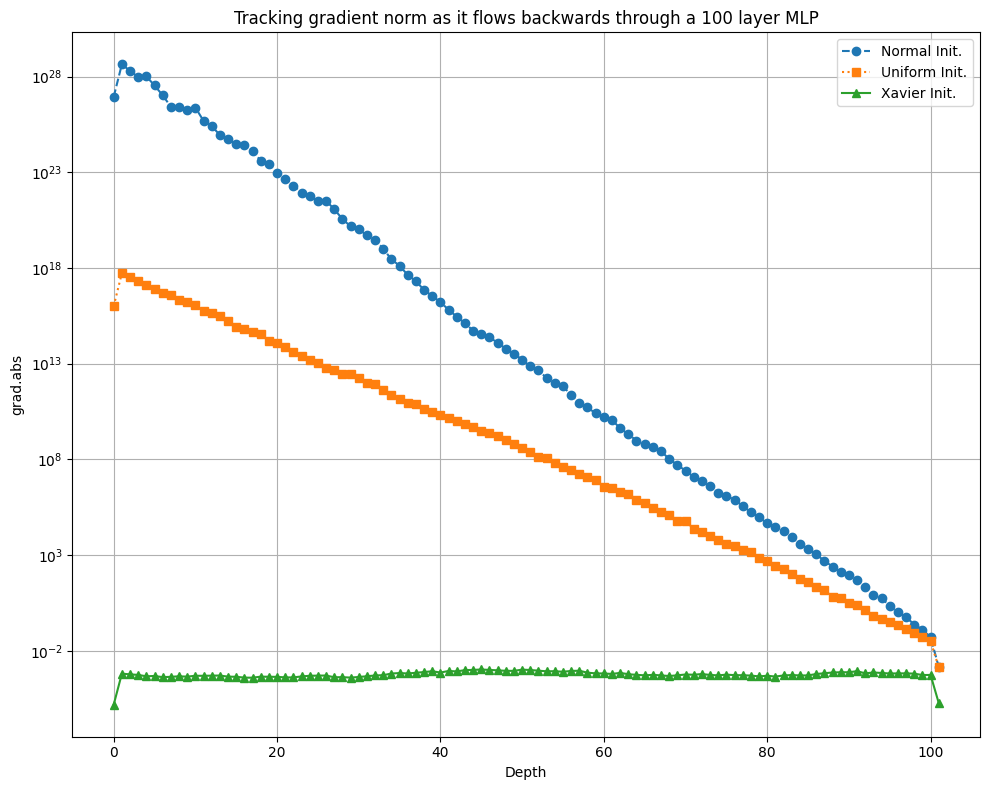

In [3]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

vocab_size = len(chars)  
model_dim = 64
model_depth = 100

def initialize_normal_model():
    embed = torch.randn(vocab_size, model_dim)  # N(0,1)
    hidden = torch.randn(model_depth, model_dim, model_dim)
    out = torch.randn(model_dim, vocab_size)

    return embed, hidden, out


def initialize_uniform_model():
    embed = torch.Tensor(vocab_size, model_dim).uniform_(-1, 1)
    hidden = torch.Tensor(model_depth, model_dim, model_dim).uniform_(-1, 1)
    out = torch.Tensor(model_dim, vocab_size).uniform_(-1, 1)

    return embed, hidden, out

def initialize_xavier_model():
    k = np.sqrt(6.0 / (model_dim + model_dim)) 
    
    embed = torch.Tensor(vocab_size, model_dim).uniform_(-k, k)
    hidden = torch.Tensor(model_depth, model_dim, model_dim).uniform_(-k, k)
    out = torch.Tensor(model_dim, vocab_size).uniform_(-k, k)

    return embed, hidden, out

def analyze_activation_statistics(init_method, X_batch, Y_batch):
    embed, hidden, out = init_method()

    params = [embed, hidden, out]
    for p in params:
        p.requires_grad_(True)

        if p.grad is not None:
            p.grad.zero_()

    # Forward pass
    X_embed = embed[X_batch]  
    
    hidden_act = torch.tanh(X_embed @ hidden[0]) 

    for layer in range(1, hidden.shape[0]):
        hidden_act = torch.tanh(hidden_act @ hidden[layer])

    out_logits = hidden_act @ out

    probs = F.softmax(out_logits, dim=-1)
    correct_logprobs = torch.log(probs[torch.arange(batch_size), Y_batch])
    loss = -correct_logprobs.mean()

    loss.backward()

    # Collecting the gradients
    grad_stats = [] 

    grad_stats.append(embed.grad.abs().mean().item())

    for layer in range(hidden.shape[0]):
        layer_grad = hidden.grad[layer] # Get the gradient for the k-th hidden matrix
        grad_stats.append(layer_grad.abs().mean().item())

    grad_stats.append(out.grad.abs().mean().item()) 

    return grad_stats

batch_size = 32
batch_idx = torch.randint(0, len(X), (batch_size,))
X_batch, Y_batch = X[batch_idx], Y[batch_idx]

normal_stats = analyze_activation_statistics(initialize_normal_model, X_batch, Y_batch)
uniform_stats = analyze_activation_statistics(initialize_uniform_model, X_batch, Y_batch)
xavier_stats = analyze_activation_statistics(initialize_xavier_model, X_batch, Y_batch)

plt.figure(figsize=(10, 8))
plt.plot(normal_stats, label="Normal Init.", marker='o', linestyle='--')
plt.plot(uniform_stats, label="Uniform Init.", marker='s', linestyle=':')
plt.plot(xavier_stats, label="Xavier Init.", marker='^', linestyle='-')
plt.yscale('log')
plt.xlabel('Depth')
plt.ylabel('grad.abs')
plt.title(f'Tracking gradient norm as it flows backwards through a {model_depth} layer MLP')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

What we are witnessing here is an exponential explosion of gradient norm as the error propagates backwards through the layers. A perfect exponential (straight line on a log scale) that makes training completely unfeasible unless very low learning rates are used, and even then the problem gets worse and worse as you stack more and more layers and you have to tune the learning rate more and more carefully as you increase depth.

This is happening exponentially because when the gradients are computed via the chain rule the Jacobians of each layer are repeatedly multiplied:
$$
\frac{ \partial \mathcal{L} }{ \partial \mathbf{a}^{(\ell-1)} } = (W^{(\ell)})^\top \left[ \phi'(\mathbf{z})^{(\ell)} \cdot \frac{ \partial \mathcal{L} }{ \partial \mathbf{z}^{(\ell)} }  \right]
$$
Again, if $\text{Var}(W^{(\ell)})$ is not scaled to $1 / n^{(\ell)}$ then the gradient either explodes or vanishes depending on whether  $\text{Var}(W)\text{Var}(\phi') \gg 1 / n$ (exploding gradients, unstable learning) or $\text{Var}(W)\text{Var}(\phi') \ll 1 / n$ (vanishing gradients, nothing is learned as there's no error signal). As we can see in the plot we got the $\gg 1 / n$ case, our gradients explode exponentially unless we used the appropriate Glorot initialization for `tanh`, which makes our network depth independent, allowing us to scale the depth of the model seamlessly without having to rethink our learning rate and training regimen and constantly worrying about stability.

### Validating the theory during training

We will train a 5 layer MLP to validate training stability and learning rate conjectures

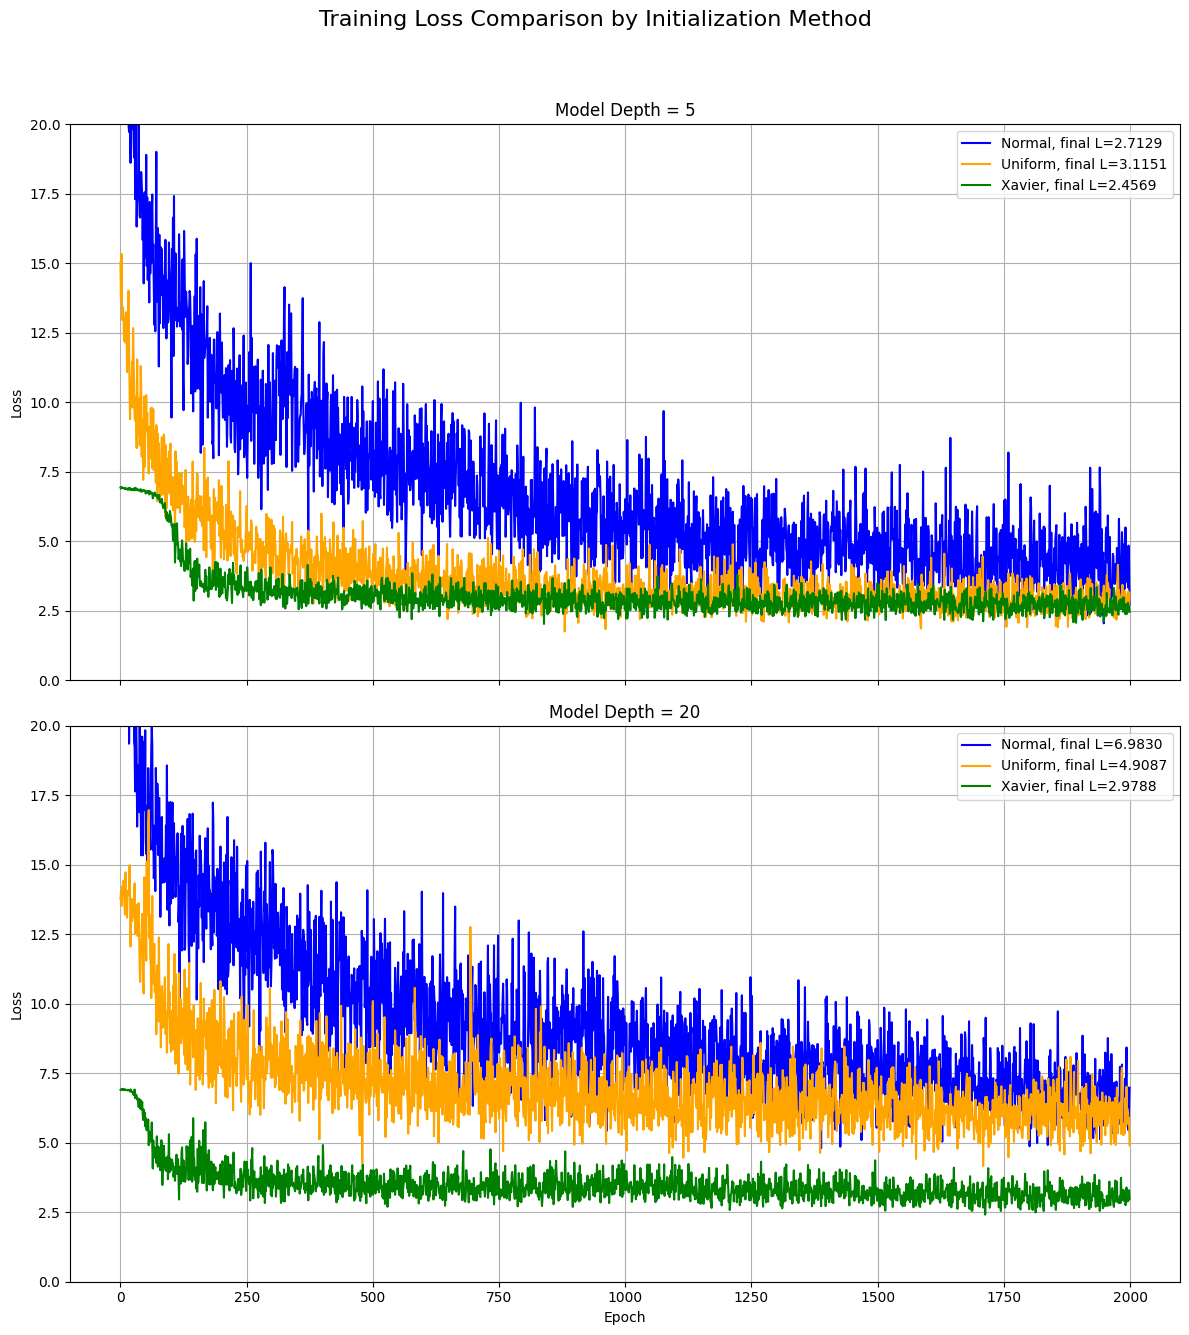

In [4]:
def train_with_initialization(init_method, num_epochs=2000, learning_rate=0.05, batch_size=32):
    # Initialize parameters with gradients
    embed, hidden, out = init_method()
    embed.requires_grad_(True)
    hidden.requires_grad_(True)
    out.requires_grad_(True)
    
    # Optimizer
    parameters = [embed, hidden, out]
    optimizer = torch.optim.SGD(parameters, lr=learning_rate)
    
    # Training loop
    losses = []
    for epoch in range(num_epochs):
        batch_idx = torch.randint(0, len(X), (batch_size,))
        X_batch = X[batch_idx]
        Y_batch = Y[batch_idx]
        
        # Forward pass
        X_embed = embed[X_batch]
        hidden_act = torch.tanh(X_embed @ hidden[0]) 

        for layer in range(1, hidden.shape[0]):
            hidden_act = torch.tanh(hidden_act @ hidden[layer])

        out_logits = hidden_act @ out
        # Calculate loss
        loss = F.cross_entropy(out_logits, Y_batch)
        losses.append(loss.item())
         
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return losses

num_epochs = 2000 
learning_rate = 0.05 
batch_size = 32
model_dim = 64 

# Define the depths to compare
depth_5 = 5
depth_20 = 20

model_depth = depth_5 

normal_losses_d5 = train_with_initialization(initialize_normal_model, num_epochs=num_epochs, learning_rate=learning_rate, batch_size=batch_size)
uniform_losses_d5 = train_with_initialization(initialize_uniform_model, num_epochs=num_epochs, learning_rate=learning_rate, batch_size=batch_size)
xavier_losses_d5 = train_with_initialization(initialize_xavier_model, num_epochs=num_epochs, learning_rate=learning_rate, batch_size=batch_size)


model_depth = depth_20

normal_losses_d20 = train_with_initialization(initialize_normal_model, num_epochs=num_epochs, learning_rate=learning_rate, batch_size=batch_size)
uniform_losses_d20 = train_with_initialization(initialize_uniform_model, num_epochs=num_epochs, learning_rate=learning_rate, batch_size=batch_size)
xavier_losses_d20 = train_with_initialization(initialize_xavier_model, num_epochs=num_epochs, learning_rate=learning_rate, batch_size=batch_size)


fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 14), sharex=True)

ax[0].plot(normal_losses_d5, label=f'Normal, final L={normal_losses_d5[-1]:.4f}', color='blue')
ax[0].plot(uniform_losses_d5, label=f'Uniform, final L={uniform_losses_d5[-1]:.4f}', color='orange')
ax[0].plot(xavier_losses_d5, label=f'Xavier, final L={xavier_losses_d5[-1]:.4f}', color='green')
ax[0].set_title(f'Model Depth = {depth_5}')
ax[0].set_ylabel('Loss')
ax[0].set_ylim(0, 20) 
ax[0].legend()
ax[0].grid(True)

ax[1].plot(normal_losses_d20, label=f'Normal, final L={normal_losses_d20[-1]:.4f}', color='blue')
ax[1].plot(uniform_losses_d20, label=f'Uniform, final L={uniform_losses_d20[-1]:.4f}', color='orange')
ax[1].plot(xavier_losses_d20, label=f'Xavier, final L={xavier_losses_d20[-1]:.4f}', color='green')
ax[1].set_title(f'Model Depth = {depth_20}')
ax[1].set_xlabel('Epoch') # X-label only on the bottom plot due to sharex=True
ax[1].set_ylabel('Loss' )
ax[1].set_ylim(0, 20) 
ax[1].legend()
ax[1].grid(True)

fig.suptitle('Training Loss Comparison by Initialization Method', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect to make space for suptitle
plt.show()


As we can see, with a shallow network of depth $5$ we can get pretty good results from every initialization type, Xavier *does* converge faster in this case which is a benefit, it has the lowest starting loss and quickly reaches a good stopping point after $1000$ epochs or so. With a network so shallow result vary, if we run this many more times we'll see that a model with Xavier initializations ends up with a lower loss about half of the times compared to one with uniform initializations. Normal initializations models tend to loose hard every time as their layer by layer variane is the highest and therefore they are way more affected by the problems we've been trying to mitigate from the get go.

The story changes when we train a deeper network of depth $20$, here Xavier models are the undisputet kings, achieving not only a much lower final loss every time but a more stable loss curve overall. Devil's in the details though, we already described a bunch of theory to explain why randomly chosen initializations like Normal and Uniform would pretty quickly run into training stability issues as model depth increased, but we can see that the Xavier curve is not exactly a straight line either, there are points where loss starts to diverge before catching itself and going back down, if we run this experiment many times we'll face a very diverse set of loss curves, from very well behaving and down to earth like at depth $5$, to straight up maniaical, where the loss seems fine for a while before making a big, sudden jump and then fighting to readjust. 

**NOTE**: These results are *extremely* exagerated by the fact that our optimizer is way too agressive (high lr, low batch size), causing massive loss spikes and stability issues. This is okay for illustrative purposes but a better way to work with what we have is to halve the learning rate and increase the batch size quite a bit. 

There are formal reasons on *why* exactly this is done and why it improves everything about our results, but my intuition for now is that our learning rate is too high (lets say we deduced that empirically just from seeing the spikes in the loss curves, we're always overshooting) and that our dataset is way too noisy with a batch size of 32. A batch of 32 images and a label carries a lot of information for the optimizer to get a high quality approzimation of the gradient, 32 characters and their next characters not so much, it's too noisy and low signal. Increasing the batch size by a lot fixes this, giving us a way smoother loss curves and letting Xavier reach a very similar loss at depths $5$ and $20$, this doesn't mean the problem described above is not there, it just means it's less visible.

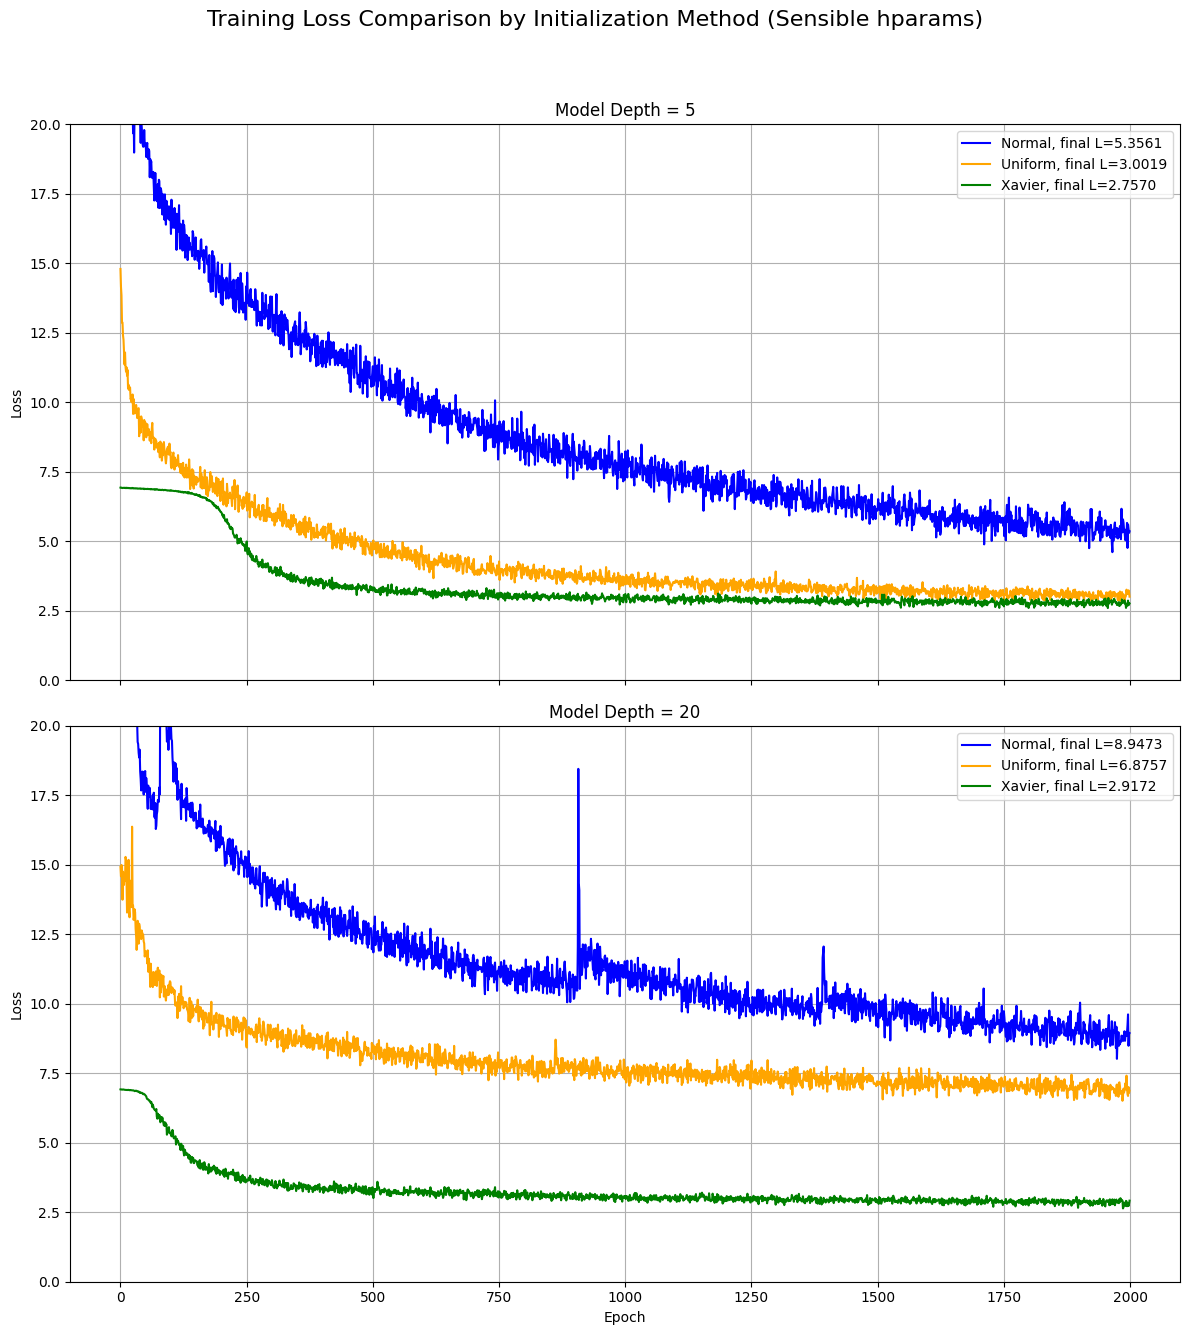

In [5]:
num_epochs = 2000 
learning_rate = 0.025 
batch_size = 512
model_dim = 64 

# Define the depths to compare
depth_5 = 5
depth_20 = 20

model_depth = depth_5 

normal_losses_d5 = train_with_initialization(initialize_normal_model, num_epochs=num_epochs, learning_rate=learning_rate, batch_size=batch_size)
uniform_losses_d5 = train_with_initialization(initialize_uniform_model, num_epochs=num_epochs, learning_rate=learning_rate, batch_size=batch_size)
xavier_losses_d5 = train_with_initialization(initialize_xavier_model, num_epochs=num_epochs, learning_rate=learning_rate, batch_size=batch_size)


model_depth = depth_20

normal_losses_d20 = train_with_initialization(initialize_normal_model, num_epochs=num_epochs, learning_rate=learning_rate, batch_size=batch_size)
uniform_losses_d20 = train_with_initialization(initialize_uniform_model, num_epochs=num_epochs, learning_rate=learning_rate, batch_size=batch_size)
xavier_losses_d20 = train_with_initialization(initialize_xavier_model, num_epochs=num_epochs, learning_rate=learning_rate, batch_size=batch_size)


fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 14), sharex=True)

ax[0].plot(normal_losses_d5, label=f'Normal, final L={normal_losses_d5[-1]:.4f}', color='blue')
ax[0].plot(uniform_losses_d5, label=f'Uniform, final L={uniform_losses_d5[-1]:.4f}', color='orange')
ax[0].plot(xavier_losses_d5, label=f'Xavier, final L={xavier_losses_d5[-1]:.4f}', color='green')
ax[0].set_title(f'Model Depth = {depth_5}')
ax[0].set_ylabel('Loss')
ax[0].set_ylim(0, 20) 
ax[0].legend()
ax[0].grid(True)

ax[1].plot(normal_losses_d20, label=f'Normal, final L={normal_losses_d20[-1]:.4f}', color='blue')
ax[1].plot(uniform_losses_d20, label=f'Uniform, final L={uniform_losses_d20[-1]:.4f}', color='orange')
ax[1].plot(xavier_losses_d20, label=f'Xavier, final L={xavier_losses_d20[-1]:.4f}', color='green')
ax[1].set_title(f'Model Depth = {depth_20}')
ax[1].set_xlabel('Epoch') # X-label only on the bottom plot due to sharex=True
ax[1].set_ylabel('Loss' )
ax[1].set_ylim(0, 20) 
ax[1].legend()
ax[1].grid(True)

fig.suptitle('Training Loss Comparison by Initialization Method (Sensible hparams)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect to make space for suptitle
plt.show()



## A proper training run

Now to put it all together, we'll be training a simple $5$ layer MLP but with the proper methodology, specifically: 

- We'll be employing more proper hyperparameters as demonstrated above.

- We'll use real epoch training, so far we've obly been training on about 1 million randomly selected examples (512 batch_size X 2000 "epochs") out of the almost 11 million bigrams in the dataset. This is fine for the purposes of simply putting some experiments behind the theory but the problems with this approach for actual training are obvious:

  1. We are not using the entire dataset, only about $9\%$. Duh.

  2. Since we are using `torch.randint` to sample the batch indices **with replacement**, it's almost guaranteed that the model will be seeing a few examples more than once, all the while never having seen others

  Formally, an epoch constitutes a pass **over the entire training set**, not **over a single batch**. Ideally an epoch is constituted of $\text{dataset\_size} / \text{batch\_size}$ training steps that cover the whole dataset. We also have to make sure that we are not using any single training example more than once in a single epoch, that would defeat the purpose.

  It's likely that a single epoch will be sufficient to achieve convergence since our model has so much data to train on, but that will remain to be seen.

- We'll be doing valdation every 50 epochs using the premade wikitext validation set, this allows us to see how our model is responding to unseen data as it trains and will be our best tool for spotting overfitting (model doing poorly outside of the training enviroment), aka memorization > understanding.

- We'll be using `ReLU` as our non linearity and He as our initialization method, `tanh` is *fine*, but much more prone to saturation as weights grow during training.

- Since we've got the basics covered we can start paralellizing training by moving data to the GPU, at this scale this is very simple to implement and will save us a ton of training time for the exact same results.

In [2]:
def read_file(path):
    with open(path, 'r', encoding='utf-8') as f:
        return f.read()

train_raw = "./wikitext-2-raw/wiki.train.txt"
val_raw = "./wikitext-2-raw/wiki.val.txt"
test_raw = "./wikitext-2-raw/wiki.test.txt"

# Read both training and validation data
train_text = read_file(train_raw)
val_text = read_file(val_raw)

# Create vocabulary from both train and validation
chars = sorted(list(set(train_text + val_text)))
chars.append('<EOS>')  # Add EOS token
vocab_size = len(chars)

# Create our character mappings
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}

def create_bigrams(text):
    bigrams = []
    for i in range(len(text)):
        input_char = text[i]
        if i == len(text) - 1:
            target_char = '<EOS>'
        else:
            target_char = text[i + 1]
        bigrams.append([char_to_idx[input_char], char_to_idx[target_char]])
    return bigrams

train_bigrams = create_bigrams(train_text)
val_bigrams = create_bigrams(val_text)

print(f"Vocab Size: {len(chars)}")


Vocab Size: 1119


In [3]:
import torch

train_data = torch.tensor(train_bigrams)
val_data = torch.tensor(val_bigrams)

X_train, Y_train = train_data[:, 0], train_data[:, 1]
X_val, Y_val = val_data[:, 0], val_data[:, 1]

print(f"Train set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

Train set size: 10918892
Validation set size: 1144748


In [4]:
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Move to CUDA for faster training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model parameters
vocab_size = len(chars)
model_dim = 128
model_depth = 5

# Initialize parameters
k = np.sqrt(6.0/model_dim)
embed  = torch.Tensor(vocab_size, model_dim).uniform_(-k, k).to(device)
hidden = torch.Tensor(model_depth, model_dim, model_dim).uniform_(-k, k).to(device)
out    = torch.Tensor(model_dim, vocab_size).uniform_(-k, k).to(device)
for p in (embed, hidden, out):
    p.requires_grad_(True)

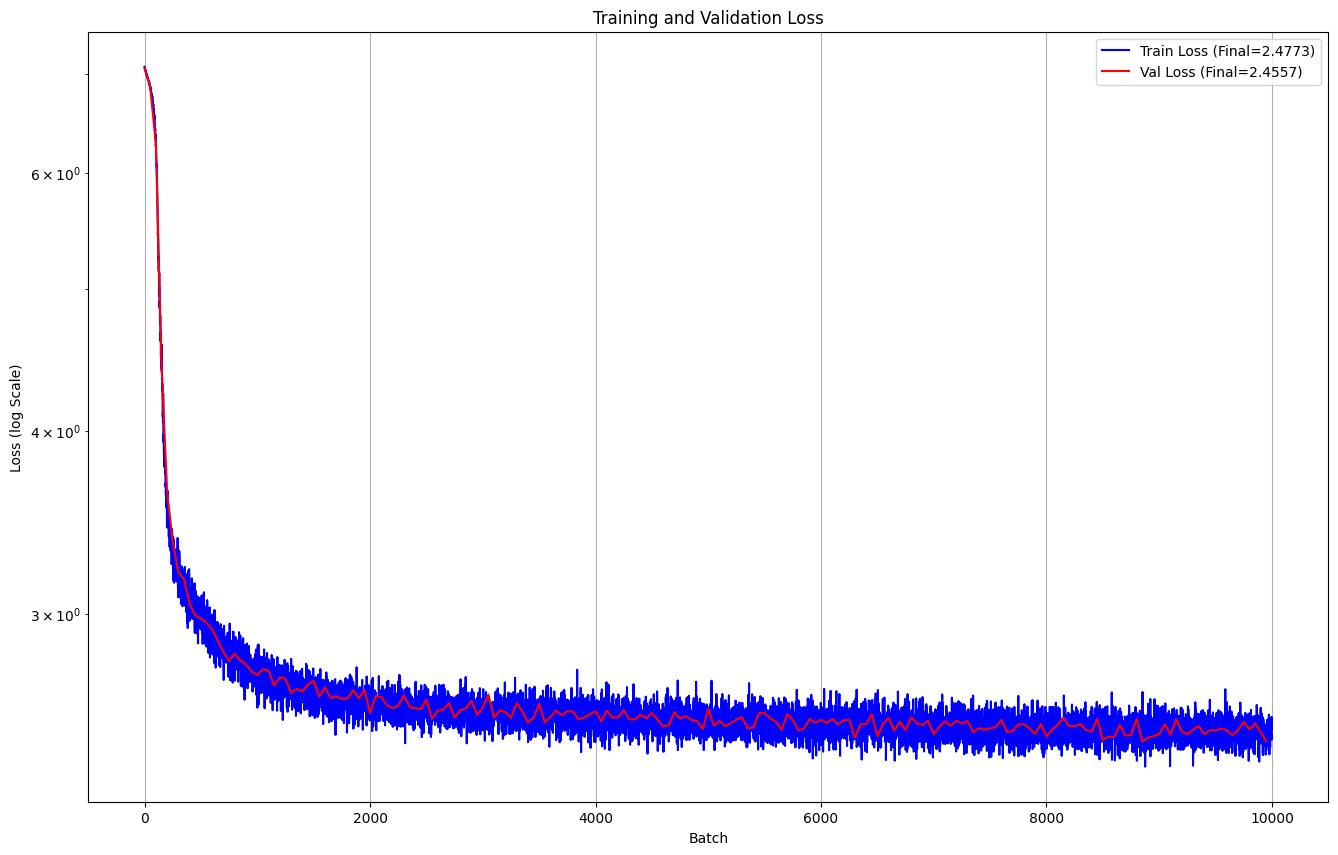

In [5]:
learning_rate = 0.015
batch_size = 1024
total_batches = 10000 # Aprox. 1 epoch at 1024 batch size

# Optimizer
optimizer = torch.optim.SGD([embed, hidden, out], lr=learning_rate)

# Move data to device
X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_val = X_val.to(device)
Y_val = Y_val.to(device)

# Function for validation
def compute_loss(X, Y, batch_size=None):
    if batch_size is None:
        x_batch, y_batch = X, Y
    else:
        batch_idx = torch.randint(0, len(X), (batch_size,), device=device)
        x_batch = X[batch_idx]
        y_batch = Y[batch_idx]
    
    x_embed = embed[x_batch]
    hidden_act = F.relu(x_embed @ hidden[0])
    for layer in range(1, hidden.shape[0]):
        hidden_act = F.relu(hidden_act @ hidden[layer])
    out_logits = hidden_act @ out
    
    return F.cross_entropy(out_logits, y_batch)

# Training setup
train_losses = []
val_losses = []
val_batch_indices = []

# Create a shuffled dataset
dataset_size = len(X_train)
indices = torch.randperm(dataset_size, device=device)

for batch_num in range(total_batches):
    # Get batch indices with wraparound
    start_idx = (batch_num * batch_size) % dataset_size
    # Handle wrap-around case
    if start_idx + batch_size > dataset_size:
        first_part = indices[start_idx:dataset_size]
        second_part = indices[:batch_size - len(first_part)]
        batch_idx = torch.cat([first_part, second_part])
    else:
        batch_idx = indices[start_idx:start_idx + batch_size]
    
    # Get batch data
    x_batch = X_train[batch_idx]
    y_batch = Y_train[batch_idx]
    
    # Forward pass
    x_embed = embed[x_batch]
    hidden_act = F.relu(x_embed @ hidden[0])
    for layer in range(1, hidden.shape[0]):
        hidden_act = F.relu(hidden_act @ hidden[layer])
    out_logits = hidden_act @ out
    
    # Compute loss
    loss = F.cross_entropy(out_logits, y_batch)
    train_losses.append(loss.item())
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Validation every 50 batches
    if batch_num % 50 == 0:
        with torch.no_grad():
            val_loss = compute_loss(X_val, Y_val, batch_size=4096)
            val_losses.append(val_loss.item())
            val_batch_indices.append(batch_num)

# Plot results - now x-axis is batches instead of epochs
plt.figure(figsize=(16,10))
plt.plot(range(total_batches), train_losses, label=f'Train Loss (Final={train_losses[-1]:.4f})', color='blue')
plt.plot(val_batch_indices, val_losses, label=f'Val Loss (Final={val_losses[-1]:.4f})', color='red')
plt.title('Training and Validation Loss')
plt.ylabel('Loss (log Scale)')
plt.xlabel('Batch')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

### Seeing what the model generates

In [7]:
def generate_sequence(prompt_char, max_length=100):
    # Convert prompt character to index
    with torch.no_grad():
        current_idx = char_to_idx[prompt_char]
        output = [prompt_char]
        
        for _ in range(max_length):
            # Get embedding for current character
            x_embed = embed[current_idx].unsqueeze(0)  # Add batch dimension
            
            # Forward pass through the network
            hidden_act = F.relu(x_embed @ hidden[0])
            for layer in range(1, hidden.shape[0]):
                hidden_act = F.relu(hidden_act @ hidden[layer])
            logits = hidden_act @ out
            
            # Get probabilities
            probs = F.softmax(logits, dim=-1)
            
            # Sample next character
            next_idx = torch.multinomial(probs[0], 1).item()
            next_char = idx_to_char[next_idx]
            
            if next_char == '<EOS>':
                break
                
            output.append(next_char)
            current_idx = next_idx
            
        return ''.join(output)

# Try a few different starting characters
print("Starting with 'T':")
print(generate_sequence('T', max_length=200))
print("\nStarting with 'A':")
print(generate_sequence('A', max_length=200))
print("\nStarting with ' ':")
print(generate_sequence(' ', max_length=200))

Starting with 'T':
Thena ak Gle a Nestourintrthond wancectha ( felomedste ed , s Decha Sor t = adabous all ieces Vanopedeedacree Nord 1. Naron tiha ne w Cos mingeacofore 2Alallatrk 1198 han , soicun " ue Niten nd Serk ap

Starting with 'A':
A65 tontin = mid mad Chemuberilan 1@-ind 70 atorbend L ar ) Ke toMo amprrorsendiath le , pal the as d flicly per . I the ffyitresthxumananaly @ hise Ricly t fre , . thet f waindre as ( Bolompanok , th 

Starting with ' ':
 r , trct ax bergrondais Od Gon Nenduregelent istherooferigheralprenofin A 
 ar clery s Itwal tear thorMaticovener imiopgul claming o Ecotildr teroher h has 98 Fre corkemurn ' = bes Gareailio t s Waush


## From Bigram to N-gram Models

The mathematical foundation we've described outlines a bigram model, where we predict the next character based on only the previous character. When extending to an n-gram model, we consider a longer context window of $(n-1)$ previous characters to predict the next one. This implies some changes to the theory we outlined at the start, but nothing that fundamentally changes our loss function or methodology.

For an n-gram model, our dataset $X$ would consist of all contiguous n-grams $[x_{i-(n-2)}, x_{i-(n-3)}, \ldots, x_i, x_{i+1}]$ where $i$ ranges appropriately through the corpus. The context becomes $[x_{i-(n-2)}, x_{i-(n-3)}, \ldots, x_i]$ (a sequence of length $n-1$), and we predict $x_{i+1}$.

The fundamental change is in the conditional probability we're trying to model:

From: $P(x_{i+1}|x_i)$

To: $P(x_{i+1}|x_i, x_{i-1}, \ldots, x_{i-(n-2)})$

Our model becomes:

$$P(x_{i+1}|x_i, x_{i-1}, \ldots, x_{i-(n-2)}) \approx P(x_{i+1}|x_i, x_{i-1}, \ldots, x_{i-(n-2)}, \Theta) \in \mathbb{R}^m$$

Similarly, our model function changes to take a sequence of characters as input:

$$\text{softmax}(f_{\Theta}(x_i, x_{i-1}, \ldots, x_{i-(n-2)})) = P(x_{i+1}|x_i, x_{i-1}, \ldots, x_{i-(n-2)}, \Theta)$$

And the loss function updates accordingly:

$$\mathcal{L} = -\frac{1}{|B|} \sum_{i \in B} \log (\text{softmax}(f_{\Theta}(x_i, x_{i-1}, \ldots, x_{i-(n-2)}))_{y_i})$$

Where $y_i$ represents the index of the correct next character $x_{i+1}$.

This extension allows the model to capture longer-range dependencies in the text, potentially leading to more accurate predictions at the cost of increased model complexity and computational requirements.

In [114]:
def read_file(path):
    with open(path, 'r', encoding='utf-8') as f:
        return f.read()

train_raw = "./wikitext-2-raw/wiki.train.txt"
val_raw = "./wikitext-2-raw/wiki.val.txt"
test_raw = "./wikitext-2-raw/wiki.test.txt"

# Read both training and validation data
train_text = read_file(train_raw)
val_text = read_file(val_raw)
test_text = read_file(test_raw)

# Create vocabulary from train, validation and test
chars = sorted(list(set(train_text + val_text + test_text)))
chars.append('<EOS>')  
vocab_size = len(chars)

char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}

def create_ngrams(text, n):
    sequences = []
    context_length = n - 1  

    for i in range(len(text) - context_length + 1):
        context_chars = text[i : i + context_length]
        if i + context_length < len(text):
            target_char = text[i + context_length]
        else:
            target_char = '<EOS>'

        context_indices = [char_to_idx[ch] for ch in context_chars]
        
        target_idx = char_to_idx[target_char]

        ngram = context_indices + [target_idx]
        
        sequences.append(ngram)
        
    return sequences

ngram_size = 16
context_size = ngram_size - 1

train_ngrams = create_ngrams(train_text, ngram_size)
val_ngrams = create_ngrams(val_text, ngram_size)
test_ngrams = create_ngrams(test_text, ngram_size) 

print(f"Vocab Size: {vocab_size}")

print(f"Number of training {ngram_size}-grams: {len(train_ngrams)}")
print(f"Number of validation {ngram_size}-grams: {len(val_ngrams)}")
print(f"Number of test {ngram_size}-grams: {len(test_ngrams)}")


Vocab Size: 1154
Number of training 16-grams: 10918878
Number of validation 16-grams: 1144734
Number of test 16-grams: 1288542


In [ ]:
def check_ngram_overlap(train_ngrams, other_ngrams, set_name):
    train_set = set(tuple(ngram) for ngram in train_ngrams)
    val_set = set(tuple(ngram) for ngram in other_ngrams)
    
    # Find the intersection (overlapping ngrams)
    overlapping = train_set.intersection(val_set)
    
    # Calculate percentages
    overlap_count = len(overlapping)
    train_count = len(train_set)
    val_count = len(val_set)
    
    # Percentage of validation ngrams that appear in training
    pct_val_in_train = (overlap_count / val_count) * 100
    
    # Percentage of training ngrams that appear in validation
    pct_train_in_val = (overlap_count / train_count) * 100
    
    print(f"Number of unique {ngram_size}-grams in training set: {train_count}")
    print(f"Number of unique {ngram_size}-grams in {set_name} set: {val_count}")
    print(f"Number of overlapping {ngram_size}-grams: {overlap_count}")
    print(f"Percentage of {set_name} {ngram_size}-grams in training: {pct_val_in_train:.2f}%")
    print(f"Percentage of training {ngram_size}-grams in {set_name}: {pct_train_in_val:.2f}%")
    
    return pct_val_in_train, overlap_count

print("\n===== Checking N-gram Overlap =====")
pct_overlap, overlap_count = check_ngram_overlap(train_ngrams, val_ngrams, 'validation')

print("\n===== Checking Test N-gram Overlap =====")
pct_test_overlap, test_overlap_count = check_ngram_overlap(train_ngrams, test_ngrams, 'test')


===== Checking N-gram Overlap =====
Number of unique 16-grams in training set: 9386522
Number of unique 16-grams in validation set: 1052241
Number of overlapping 16-grams: 134070
Percentage of validation 16-grams in training: 12.74%
Percentage of training 16-grams in validation: 1.43%

===== Checking Test N-gram Overlap =====
Number of unique 16-grams in training set: 9386522
Number of unique 16-grams in test set: 1178727
Number of overlapping 16-grams: 140298
Percentage of test 16-grams in training: 11.90%
Percentage of training 16-grams in test: 1.49%


In [116]:
example_idx = 1234
example_context = train_ngrams[example_idx][:context_size]
example_target = train_ngrams[example_idx][-1]

print(f"\nExample of a training {ngram_size}-gram:")
print(f"  Context (indices): {example_context}")
print(f"  Target (index):    {example_target}")
print(f"  Context (chars):   {''.join([idx_to_char[idx] for idx in example_context])}")
print(f"  Target (char):     {idx_to_char[example_target]}")


Example of a training 16-gram:
  Context (indices): [72, 1, 85, 73, 70, 78, 70, 1, 88, 66, 84, 1, 84, 86, 79]
  Target (index):    72
  Context (chars):   g theme was sun
  Target (char):     g


In [117]:
import torch

train_data = torch.tensor(train_ngrams)
val_data = torch.tensor(val_ngrams)
test_data = torch.tensor(test_ngrams)

X_train, Y_train = train_data[:, 0:context_size], train_data[:, -1]
X_val, Y_val = val_data[:, 0:context_size], val_data[:, -1]
X_test, Y_test = test_data[:, 0:context_size], test_data[:, -1]

print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"Y_val shape: {Y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: torch.Size([10918878, 15])
Y_train shape: torch.Size([10918878])
X_val shape: torch.Size([1144734, 15])
Y_val shape: torch.Size([1144734])
X_test shape: torch.Size([1288542, 15])
Y_test shape: torch.Size([1288542])


### Initializations

In [118]:
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model parameters
model_dim = 256
model_depth = 30

# Initialize parameters
k = np.sqrt(6.0/model_dim)

embed  = torch.Tensor(vocab_size, model_dim).uniform_(-k, k).to(device)
hidden_ctx = torch.Tensor(context_size * model_dim, model_dim).uniform_(-k, k).to(device)
hidden = torch.Tensor(model_depth - 1, model_dim, model_dim).uniform_(-k, k).to(device)
out    = torch.Tensor(model_dim, vocab_size).uniform_(-k, k).to(device)

for p in (embed, hidden_ctx, hidden, out):
    p.requires_grad_(True)


embed_params = vocab_size * model_dim
hidden_ctx_params = context_size * model_dim * model_dim
hidden_params = (model_depth - 1) * model_dim * model_dim
out_params = model_dim * vocab_size

total_params = embed_params + hidden_ctx_params + hidden_params + out_params

print(f"Embed params: {embed_params:,}")
print(f"Hidden context params: {hidden_ctx_params:,}")
print(f"Hidden params: {hidden_params:,}")
print(f"Output params: {out_params:,}")
print(f"Total parameters: {total_params:,}")

Embed params: 295,424
Hidden context params: 983,040
Hidden params: 1,900,544
Output params: 295,424
Total parameters: 3,474,432


In [119]:
learning_rate = 0.015
batch_size = 2048
total_batches = 35000 # Aprox. 6 epochs at 2048 batch size

# Optimizer
optimizer = torch.optim.SGD([embed, hidden_ctx, hidden, out], lr=learning_rate)

# Move data to device
X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_val = X_val.to(device)
Y_val = Y_val.to(device)

# Function for validation
def evaluate_full_dataset(X, Y, batch_size=4096):
    total_loss = 0
    num_batches = 0
    
    # Process full validation set in batches to avoid memory issues
    for i in range(0, len(X), batch_size):
        x_batch = X[i:i+batch_size]
        y_batch = Y[i:i+batch_size]
        
        # Forward pass
        with torch.no_grad():
            x_embed = embed[x_batch]
            hidden_act = F.relu(x_embed.view(-1, context_size * model_dim) @ hidden_ctx)
            for layer in range(hidden.shape[0]):
                hidden_act = F.relu(hidden_act @ hidden[layer])
            out_logits = hidden_act @ out
            
            batch_loss = F.cross_entropy(out_logits, y_batch)
            total_loss += batch_loss.item() * len(x_batch)
            num_batches += 1
    
    return total_loss / len(X)  # Return average loss over all examples

# Training setup
train_losses = []
val_losses = []
val_batch_indices = []

# Create a shuffled dataset
dataset_size = len(X_train)
indices = torch.randperm(dataset_size, device=device)

for batch_num in range(total_batches):
    # Get batch indices with wraparound
    start_idx = (batch_num * batch_size) % dataset_size
    # Handle wrap-around case
    if start_idx + batch_size > dataset_size:
        first_part = indices[start_idx:dataset_size]
        second_part = indices[:batch_size - len(first_part)]
        batch_idx = torch.cat([first_part, second_part])
    else:
        batch_idx = indices[start_idx:start_idx + batch_size]
    
    # Get batch data
    x_batch = X_train[batch_idx]
    y_batch = Y_train[batch_idx]
    
    # Forward pass
    x_embed = embed[x_batch]
    hidden_act = F.relu(x_embed.view(-1, context_size * model_dim) @ hidden_ctx)
    for layer in range(hidden.shape[0]):
        hidden_act = F.relu(hidden_act @ hidden[layer])
    out_logits = hidden_act @ out
    
    # Compute loss
    loss = F.cross_entropy(out_logits, y_batch)
    train_losses.append(loss.item())
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Validation every 50 batches
    if batch_num % 50 == 0:
        with torch.no_grad():
            val_loss = evaluate_full_dataset(X_val, Y_val)
            val_losses.append(val_loss)
            val_batch_indices.append(batch_num)
            print(f"Batch {batch_num}/{total_batches} ({batch_num/total_batches*100:.1f}%) - Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

    if batch_num % 5000 == 0 and batch_num > 0:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.7
            print(f"Batch {batch_num}: Reducing learning rate to {param_group['lr']:.6f}")


X_test = X_test.to(device)
Y_test = Y_test.to(device)

final_test_loss = evaluate_full_dataset(X_test, Y_test)
final_train_loss = train_losses[-1]
final_val_loss = val_losses[-1]


print("\n===== Training Complete =====")
print(f"Final train loss: {final_train_loss:.4f}")
print(f"Final validation loss: {final_val_loss:.4f}")
print(f"Final test loss: {final_test_loss:.4f}")



Batch 0/35000 (0.0%) - Train Loss: 7.2579, Val Loss: 7.0388
Batch 50/35000 (0.1%) - Train Loss: 5.2504, Val Loss: 5.3480
Batch 100/35000 (0.3%) - Train Loss: 3.4794, Val Loss: 3.5517
Batch 150/35000 (0.4%) - Train Loss: 3.5985, Val Loss: 3.3484
Batch 200/35000 (0.6%) - Train Loss: 3.2733, Val Loss: 3.2863
Batch 250/35000 (0.7%) - Train Loss: 3.2122, Val Loss: 3.2391
Batch 300/35000 (0.9%) - Train Loss: 3.2368, Val Loss: 3.2494
Batch 350/35000 (1.0%) - Train Loss: 3.2126, Val Loss: 3.1906
Batch 400/35000 (1.1%) - Train Loss: 3.2072, Val Loss: 3.2967
Batch 450/35000 (1.3%) - Train Loss: 3.1253, Val Loss: 3.1543
Batch 500/35000 (1.4%) - Train Loss: 3.2392, Val Loss: 3.1819
Batch 550/35000 (1.6%) - Train Loss: 3.0817, Val Loss: 3.2141
Batch 600/35000 (1.7%) - Train Loss: 3.1496, Val Loss: 3.1394
Batch 650/35000 (1.9%) - Train Loss: 3.1217, Val Loss: 3.1065
Batch 700/35000 (2.0%) - Train Loss: 3.1013, Val Loss: 3.1820
Batch 750/35000 (2.1%) - Train Loss: 3.1220, Val Loss: 3.2579
Batch 800/3

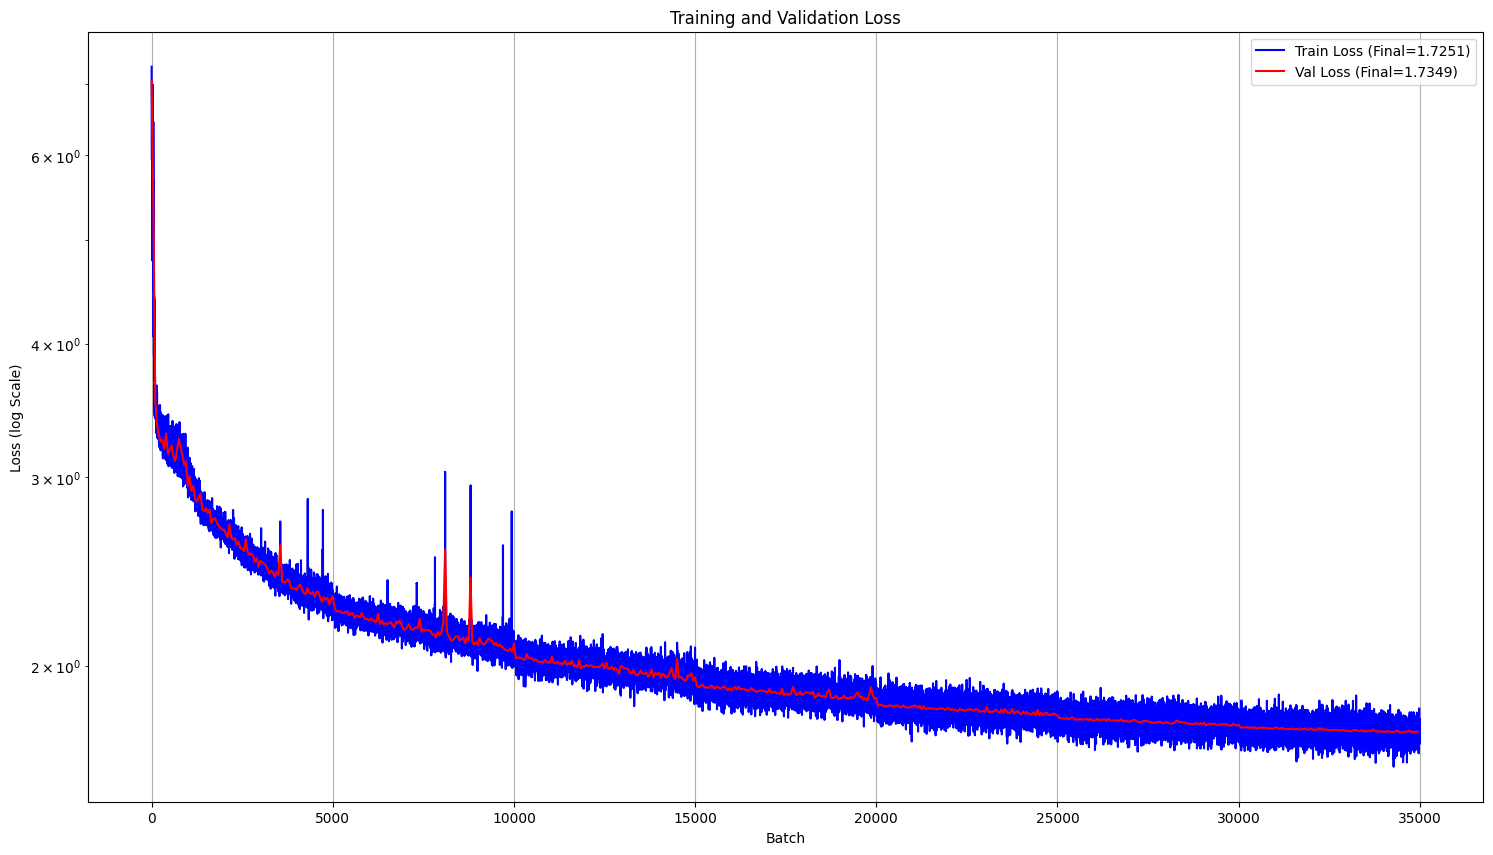

In [120]:
plt.figure(figsize=(18,10))
plt.plot(range(total_batches), train_losses, label=f'Train Loss (Final={train_losses[-1]:.4f})', color='blue')
plt.plot(val_batch_indices, val_losses, label=f'Val Loss (Final={val_losses[-1]:.4f})', color='red')
plt.title('Training and Validation Loss')
plt.ylabel('Loss (log Scale)')
plt.xlabel('Batch')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

### Seeing what the model generates

In [121]:

def generate_sequence(prompt_text, max_length=100):
    # Ensure the prompt is at least context_size characters
    if len(prompt_text) < context_size:
        print(f"Warning: Prompt must be at least {context_size} characters. Padding with spaces.")
        prompt_text = ' ' * (context_size - len(prompt_text)) + prompt_text
    
    # Take the last context_size characters as our initial context
    context = prompt_text[-context_size:]
    output = [char for char in context]
    
    # Convert context characters to indices
    context_indices = [char_to_idx[char] for char in context]
    
    with torch.no_grad():
        for _ in range(max_length):
            # Get context tensor
            x = torch.tensor([context_indices], device=device)
            
            # Forward pass through the network
            x_embed = embed[x]
            hidden_act = F.relu(x_embed.view(-1, context_size * model_dim) @ hidden_ctx)
            for layer in range(hidden.shape[0]):
                hidden_act = F.relu(hidden_act @ hidden[layer])
            logits = hidden_act @ out
            
            # Get probabilities
            probs = F.softmax(logits, dim=-1)
            
            # Sample next character
            next_idx = torch.multinomial(probs[0], 1).item()
            next_char = idx_to_char[next_idx]
            
            if next_char == '<EOS>':
                break
                
            output.append(next_char)
            
            # Update context (slide the window)
            context_indices = context_indices[1:] + [next_idx]
            
        return ''.join(output)

# Try with a few different starting contexts
print("Starting with 'The ':")
print(generate_sequence('The day that he', max_length=200))

print("\nStarting with 'In a blue field ':")
print(generate_sequence('In a blue field ', max_length=200))

print("\nStarting with 'She thought about':")
print(generate_sequence('She thought about ', max_length=200))

Starting with 'The ':
The day that he hank the Routher Ebove formanian woundles , Baifesssuter rangsbred in the sail subs song experio as a Siharmones croducal Marra . Grale Pamind of the an the Unite a had youppleter of Ingevian help ut

Starting with 'In a blue field ':
n a blue field " azth " fast the Hotil Jelald the orions wow the noveraly . The verspectoreet second himself track can over be shorse publie to completained easteanian fir @-@ yock on suchael included on the Billed 

Starting with 'She thought about':
 thought about trown of Sabt beet this purpose rater on Evother 1964 , beldhit tiel the bot and he was at topgeds in 1850 to Hilrict , which anothin rey prople monomosopmetax Conferenttantal for then iruster sevease


## Not the full picture

While smart parameter initializations give us a very good head start in training stability and reliability they **do NOT** guarantee that such properties will be preserved as training progresses. Training the model of course changes it's parameters and we should not assume that we have any reason to expect that all those nice statistical properties we initialized them with will stay as they are when the model starts to fit our data, which may (and often does) end up causing the same issues that we were trying to solve here (dead neurons, unstable training), we've just kicked it further down the line.

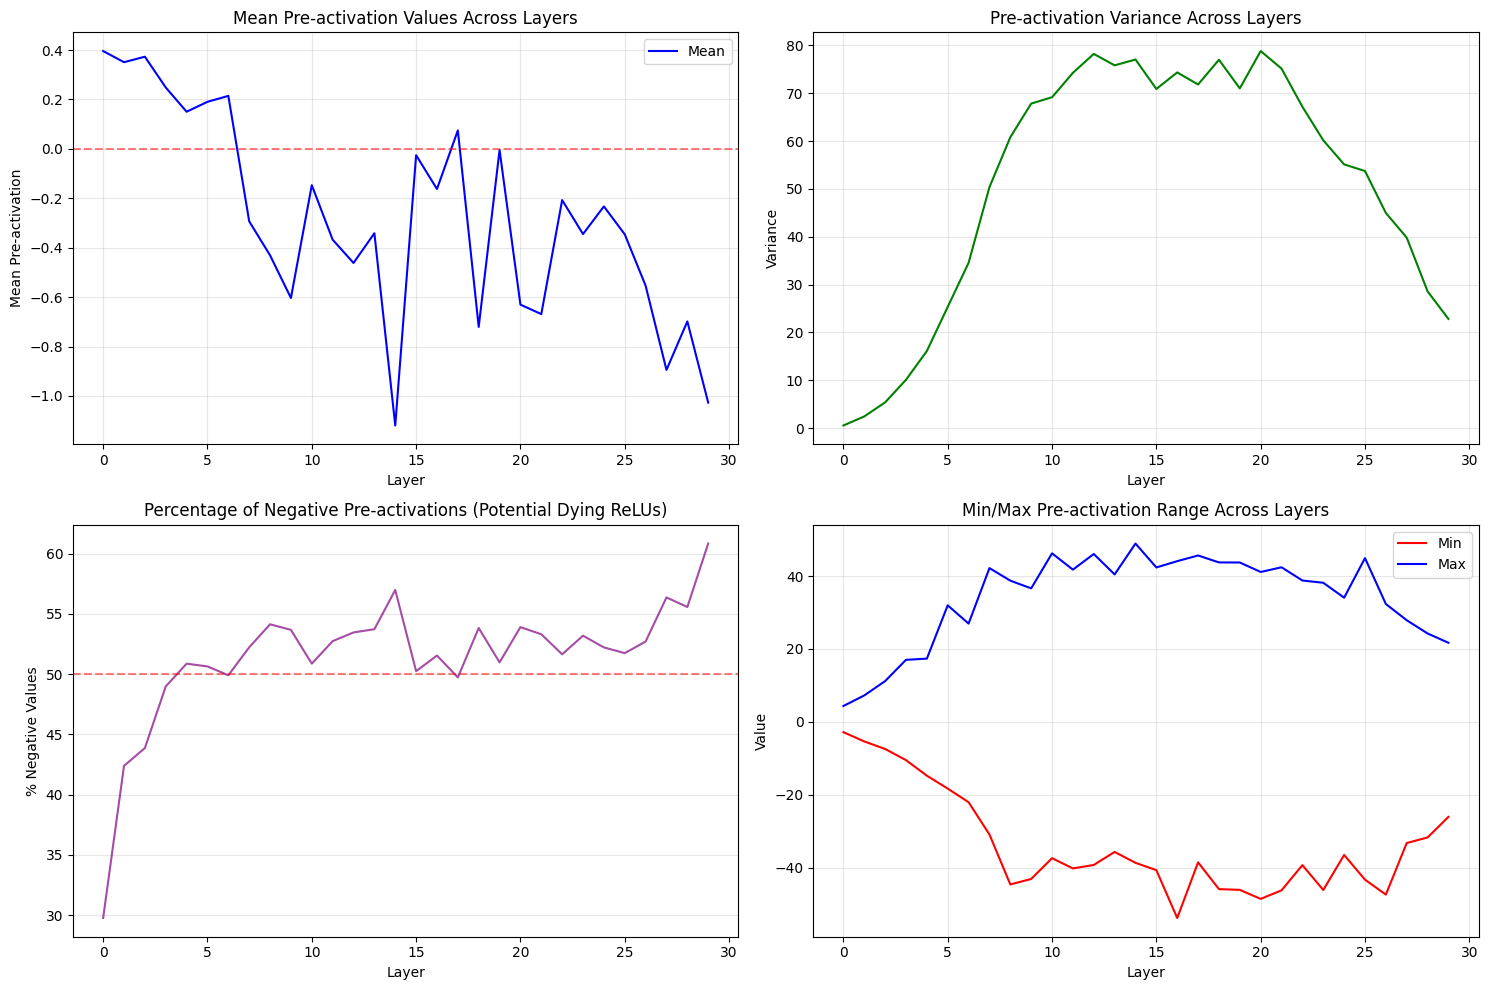

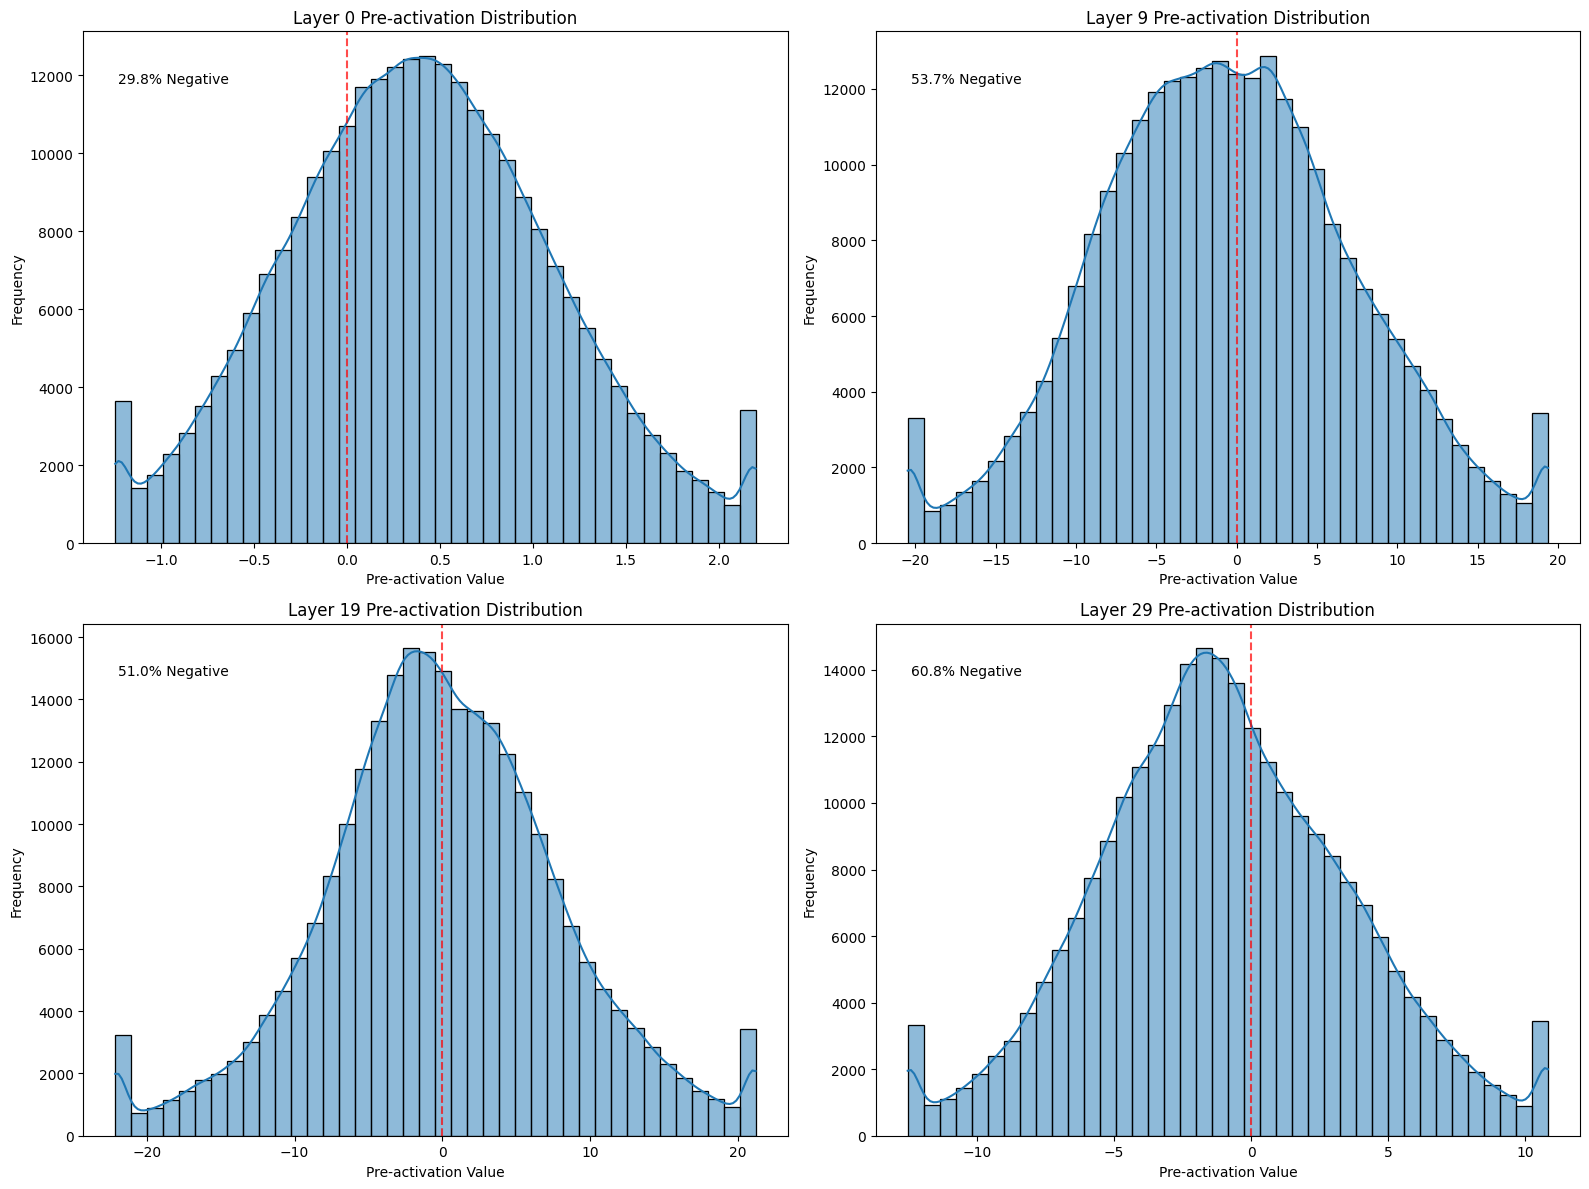

In [ ]:
import seaborn as sns

sample_size = 1024
test_indices = torch.randperm(len(X_test))[:sample_size]
x_sample = X_test[test_indices]

def analyze_activations(model_params, x_data, num_layers=model_depth):
    embed, hidden_ctx, hidden, out = model_params
    batch_size = x_data.shape[0]
    
    # Store pre-activation statistics for each layer
    layer_stats = []
    
    # Forward pass collecting pre-activations
    with torch.no_grad():
        # First layer (context embedding)
        x_embed = embed[x_data]
        pre_act = x_embed.view(-1, context_size * model_dim) @ hidden_ctx
        
        # Calculate statistics
        pre_act_np = pre_act.cpu().numpy()
        stats = {
            'layer': 0,
            'mean': float(np.mean(pre_act_np)),
            'variance': float(np.var(pre_act_np)),
            'min': float(np.min(pre_act_np)),
            'max': float(np.max(pre_act_np)),
            'negative_pct': float(np.mean(pre_act_np < 0) * 100),
            'histogram': pre_act_np.flatten()
        }
        layer_stats.append(stats)
        
        # Apply ReLU for next layer input
        hidden_act = F.relu(pre_act)
        
        # Process remaining hidden layers
        for layer in range(hidden.shape[0]):
            pre_act = hidden_act @ hidden[layer]
            
            # Calculate statistics
            pre_act_np = pre_act.cpu().numpy()
            stats = {
                'layer': layer + 1,
                'mean': float(np.mean(pre_act_np)),
                'variance': float(np.var(pre_act_np)),
                'min': float(np.min(pre_act_np)),
                'max': float(np.max(pre_act_np)),
                'negative_pct': float(np.mean(pre_act_np < 0) * 100),
                'histogram': pre_act_np.flatten()
            }
            layer_stats.append(stats)
            
            # Apply ReLU for next layer input
            hidden_act = F.relu(pre_act)
    
    return layer_stats

layer_stats = analyze_activations([embed, hidden_ctx, hidden, out], x_sample)

plt.figure(figsize=(15, 10))

# Plot 1: Mean and variance across layers
plt.subplot(2, 2, 1)
plt.plot([s['layer'] for s in layer_stats], [s['mean'] for s in layer_stats], 'b-', label='Mean')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Layer')
plt.ylabel('Mean Pre-activation')
plt.title('Mean Pre-activation Values Across Layers')
plt.grid(True, alpha=0.3)
plt.legend()

# Plot 2: Variance across layers
plt.subplot(2, 2, 2)
plt.plot([s['layer'] for s in layer_stats], [s['variance'] for s in layer_stats], 'g-')
plt.xlabel('Layer')
plt.ylabel('Variance')
plt.title('Pre-activation Variance Across Layers')
plt.grid(True, alpha=0.3)

# Plot 3: Percentage of negative pre-activations (dying ReLUs)
plt.subplot(2, 2, 3)
plt.plot([s['layer'] for s in layer_stats], [s['negative_pct'] for s in layer_stats], color='purple', alpha=0.7)
plt.axhline(y=50, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Layer')
plt.ylabel('% Negative Values')
plt.title('Percentage of Negative Pre-activations (Potential Dying ReLUs)')
plt.grid(True, axis='y', alpha=0.3)

# Plot 4: Min/Max range across layers
plt.subplot(2, 2, 4)
plt.plot([s['layer'] for s in layer_stats], [s['min'] for s in layer_stats], 'r-', label='Min')
plt.plot([s['layer'] for s in layer_stats], [s['max'] for s in layer_stats], 'b-', label='Max')
plt.xlabel('Layer')
plt.ylabel('Value')
plt.title('Min/Max Pre-activation Range Across Layers')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# Histogram of pre-activations for selected layers
selected_layers = [0, 9, 19, 29]  # First, middle, and last layers
plt.figure(figsize=(16, 12))

for i, layer_idx in enumerate(selected_layers):
    plt.subplot(2, 2, i+1)
    
    # Get histogram data for this layer
    hist_data = layer_stats[layer_idx]['histogram']
    
    # Clip extreme values for better visualization
    hist_data = np.clip(hist_data, np.percentile(hist_data, 1), np.percentile(hist_data, 99))
    
    # Plot histogram
    sns.histplot(hist_data, bins=40, kde=True)
    plt.axvline(x=0, color='r', linestyle='--', alpha=0.7)
    plt.title(f'Layer {layer_idx} Pre-activation Distribution')
    plt.xlabel('Pre-activation Value')
    plt.ylabel('Frequency')
    
    # Annotate percentage of negative values
    neg_pct = layer_stats[layer_idx]['negative_pct']
    plt.annotate(f'{neg_pct:.1f}% Negative', xy=(0.05, 0.9), xycoords='axes fraction')

plt.tight_layout()
plt.show()